<a href="https://colab.research.google.com/github/donnadamus/mlinapplabs/blob/main/2_ML_texture_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Assestment of aircraft engine vanes quality using textural features

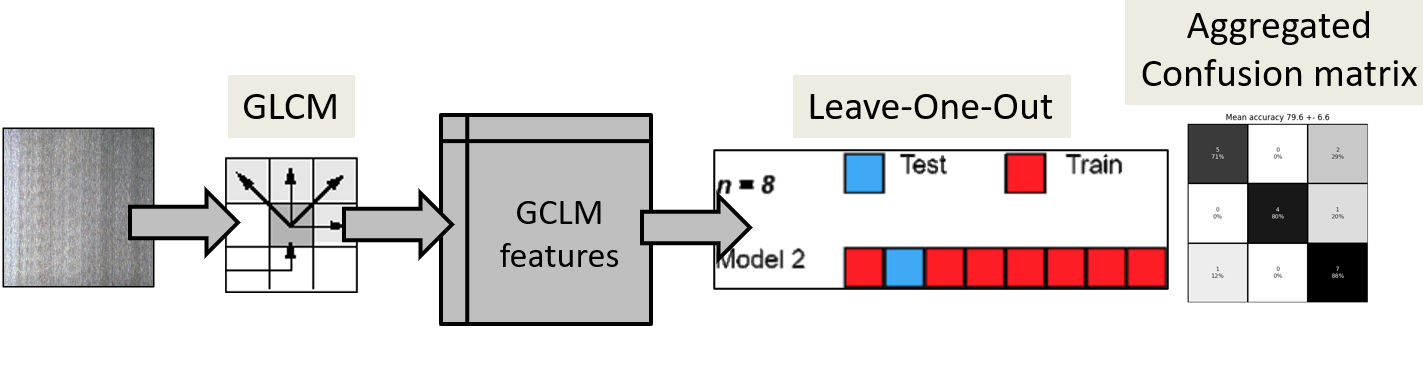

## Import and settings

In [ ]:
import os
import glob
import skimage
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
!git clone https://github.com/frpnz/teaching-Roughness.git
ROOTDIR_DATASET = "/content/teaching-Roughness/data"

Cloning into 'teaching-Roughness'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Receiving objects: 100% (25/25), 87.46 MiB | 15.58 MiB/s, done.
Updating files: 100% (22/22), done.


## Functions

In [ ]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")

def my_imshow(image, title=None):
    fig, ax = plt.subplots(1, 1)
    if len(image.shape) > 2:
        ax.imshow(image)
    else:
        ax.imshow(image, cmap=plt.cm.gray)
    ax.axis("off")
    if title:
        ax.set_title(title)

#Assignment #1: Get all filepaths ending with `".bmp"`

In [ ]:
filepaths = list()
for filename in os.listdir(ROOTDIR_DATASET):
    if filename.endswith(".bmp"):
        filepaths.append(os.path.join(ROOTDIR_DATASET, filename))

#Assignment #2: Plot some images from training set.

Create a single figure object with subplots and remove axis where not needed.
Set the filename as title for the single image (namely, the single subplot)

There exixt several package to manipulate images in Python. Consider the following three which are widly used and well documented:


*   [skimage](https://scikit-image.org/)
*   [Image module](https://pillow.readthedocs.io/en/stable/reference/Image.html) of Pillow
*   [OpenCV](https://pypi.org/project/opencv-python/)


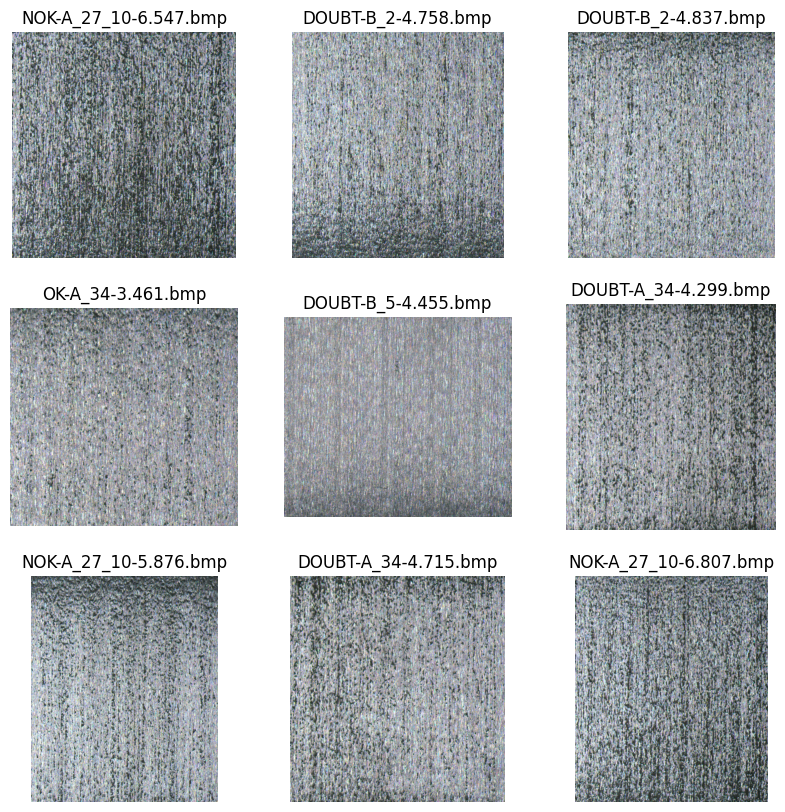

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = ax.ravel()
for j, filepath in enumerate(np.random.choice(filepaths, 9, replace=False)):
    pim = Image.open(filepath)
    ax[j].imshow(pim)
    ax[j].set_title(os.path.basename(filepath))
    ax[j].axis("off")

# Assignment #3: extract the so-called Gray-Level Co-Occurrence matrix (GLCM)

The GLCM is computed by calculating how often a pixel with the intensity (gray-level) value i occurs in a specific spatial relationship to a pixel with the value j.

To illustrate, the following figure shows how graycomatrix calculates the first three values in a GLCM. In the output GLCM, element (1, 1) contains the value 1 because there is only one instance in the input image where two horizontally adjacent pixels have the values 1 and 1, respectively. Element (1, 2) contains the value 2 because there are two instances where two horizontally adjacent pixels have the values 1 and 2. Element (1, 3) has the value 0 because there are no instances of two horizontally adjacent pixels with the values 1 and 3. graycomatrix continues processing the input image, scanning the image for other pixel pairs (i, j) and recording the sums in the corresponding elements of the GLCM.

source: https://it.mathworks.com/help/images/create-a-gray-level-co-occurrence-matrix.html

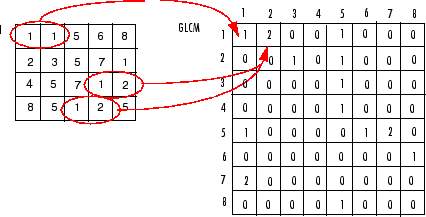

Code the pipeline to extract such GLCM.


Steps:

1. Some preprocssing operations are required. See the documentation of [skimage.feature.graycomatrix](https://scikit-image.org/docs/stable/api/skimage.feature.html#graycomatrix), paying particular attention to the required input format.
1. Exploit the function [skimage.feature.graycomatrix](https://scikit-image.org/docs/stable/api/skimage.feature.html#graycomatrix) to compute the GLCM (set a single value for `distances` and `angles` parameters).
2. Then calculate all the available texture properties of such GLCM through [graycoprops](https://scikit-image.org/docs/stable/api/skimage.feature.html#graycoprops).

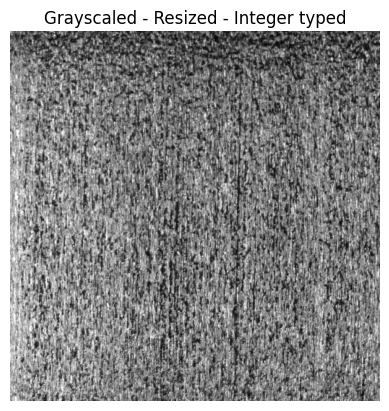

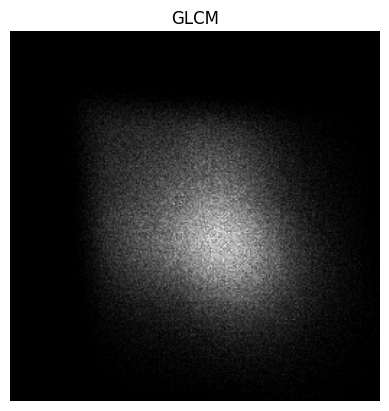

In [ ]:
# Image
I = np.array(Image.open(filepaths[0]))
G = skimage.color.rgb2gray(I)
R = skimage.transform.resize(G, (512, 512),
                             anti_aliasing=True)
R *= 255
R = R.astype(np.uint8)
glcm = skimage.feature.graycomatrix(R, distances=[3], angles=[0], levels=256,
                                    symmetric=True, normed=True)
glcm_props = list()
for prop in ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]:
    glcm_props.append(np.squeeze(skimage.feature.graycoprops(glcm, prop)))
my_imshow(image=R, title="Grayscaled - Resized - Integer typed")
my_imshow(image=np.squeeze(np.squeeze(glcm)), title="GLCM")

#Assignment #4: Create the dataset (X, y) by:

1.   Extract the GLCM from all images.
2.   Extract the summary properties from the GLCM matrix, six features in total (see [graycoprops](https://scikit-image.org/docs/stable/api/skimage.feature.html#graycoprops)). Try different values for the  `distances` and `angles` parameters of [skimage.feature.graycomatrix](https://scikit-image.org/docs/stable/api/skimage.feature.html#graycomatrix)
3.   Extract the corresponding numerical label from the filename.




In [ ]:
X_glcm = list()
X_glcm_props = list()
y = list()
label_mapping = {"OK": 0, "NOK": 1, "DOUBT": 2}
props = True

for filepath in filepaths:
    # Image
    I = np.array(Image.open(filepath))
    R = skimage.color.rgb2gray(I)
    # R = skimage.transform.resize(G, (512, 512),
    #                              anti_aliasing=True)
    R *= 255
    R = R.astype(np.uint8)
    glcm2props = skimage.feature.graycomatrix(R, distances=[3, 5, 10, 15, 20, 25, 30],
                                              angles=[0, 45, 90, 180, 270],
                                              levels=256,
                                              symmetric=True, normed=True)
    glcm_props = list()
    for prop in ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]:
        glcm_props.append(np.squeeze(skimage.feature.graycoprops(glcm2props, prop)))
    X_glcm_props.append(np.array(glcm_props))
    y.append(label_mapping[os.path.basename(os.path.splitext(filepath)[0]).split('-')[0]])

In [ ]:
X_glcm_props = np.array(X_glcm_props)
print(np.squeeze(X_glcm_props).shape)

(20, 6, 7, 5)


##Assignment #4: Reshape the dataset to be fed to sklearn, i.e. a `n_samples by m_features` matrix.
Note that the number of features depends on distances and angles parameters of skimage.feature.graycomatrix

In [ ]:
X_glcm_props = X_glcm_props.reshape(X_glcm_props.shape[0], X_glcm_props.shape[1] * X_glcm_props.shape[2] * X_glcm_props.shape[3])
y = np.array(y)
print(X_glcm_props.shape)

(20, 210)


#Assignment #5: Build and optimize the ML pipeline in a Leave-One-Out (LOO) cross-validation fashion and evaluate via confusion matrix
1.   Scale the data
2.   Implement PCA
3.   Optimize the hyperparameters of an SVM and train it
4.   Which is the most performing configuration in terms of `distances` and `angles` of the `GLCM`?


> Note that in this case study we have really few samples. For this reason, we opted to built a LOO setting in which we use multiple training set, while at each iteration one single sample is consdiered as the test set. In this way, **we are evaluating a learning method**, not just an individual learned model.





In [ ]:
from sklearn.model_selection import LeaveOneOut
label_mapping = {"OK": 0, "NOK": 1, "DOUBT": 2}
cm_aggregated = np.zeros((3, 3))
scaler = preprocessing.StandardScaler()
loo = LeaveOneOut()
loo.get_n_splits(X_glcm_props)

for i, (train_index, test_index) in enumerate(loo.split(X_glcm_props)):
    print(f"Fold {i}")
    X_train = X_glcm_props[train_index, :]
    X_test = X_glcm_props[test_index, :]
    y_train = y[train_index]
    y_test = y[test_index]

    # Scale the data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # PCA
    pca = PCA()
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    random_grid_svm = {"kernel": ["rbf", "poly", "sigmoid"],
                       "gamma": ["scale", "auto", 0.0001, 0.001, 0.01, 0.1],
                       "degree": [2, 3, 4, 5],
                       "class_weight": [None, "balanced"],
                       "C": [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}
    search = RandomizedSearchCV(estimator=SVC(),
                                param_distributions=random_grid_svm,
                                scoring="balanced_accuracy",
                                n_iter=20,
                                cv=5,
                                verbose=1,
                                random_state=42,
                                n_jobs=-1)
    search.fit(X_train, y_train)
    classifier = search.best_estimator_
    predictions = classifier.predict(X_test)
    cm_aggregated += confusion_matrix(y_test, predictions, labels=list(label_mapping.values()))

Fold 0
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 1
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 2
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 3
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 4
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 5
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 6
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 7
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 8
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 9
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 10
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 11
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 12
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 13
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 14
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 15
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 16
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fold 17
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 18
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 19
Fitting 5 folds for each of 20 candidates, totalling 100 fits


## Confusion matrix

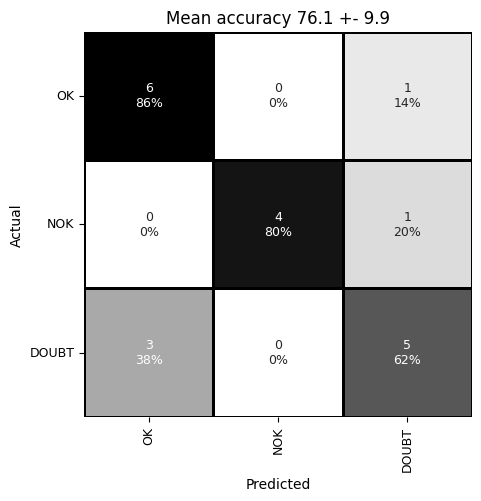

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
seaborn_cm(cm_aggregated, ax, list(label_mapping.keys()), fontsize=9, xrotation=90)